# Overview of Hacker News Analysis

Hacker News (hosted by Y Combinator) hosts a dynamic list of top news in technology and entrepreneurhsip. Using the Hacker News API, we've scraped roughly a month worth of data with the objective of discovering the core characteristics of stories that break the Top 30. 

As mentioned earlier, Hacker News hosts a dynamic list that changes frequently based on an in-house "ranking algorithm". Most of the rank of a given story is derived from score and time. Because time is core to rank, old stories float to the bottom of the list, while new content bubbles to the top. Here's a helpful resource on how stories are ranked. The data collected for the purpose of analysis exhibits "snapshots" of the Hacker News Top 30 at given points in time. Therefore, the "peak stats" of each story are likely not collected. However, the collected data gives a good view for the general patterns of top content.

In [30]:
import regex as re
import nltk
from hnews_functions import *
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import math
import itertools
from urlparse import urlparse
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Connect to SQLite database, extract all data, and show the head of the created dataframe.

In [20]:
conn = sqlite3.connect("hackernews.db")
df = pd.read_sql_query("SELECT * FROM hackernews", conn)
df.head()

,by,descendants,score,time,title,type,url,rank
0,doener,51,314,2018-01-29 18:13:29,LinuxBoot,story,https://www.linuxboot.org/,1
1,konamacona,29,85,2018-01-29 18:35:31,Show HN: Card Proxy Generator – Generate print...,story,http://mitchkeenan.com/cardproxy/,2
2,lermontov,26,86,2018-01-28 05:23:31,How Schopenhauer’s thought can illuminate a mi...,story,https://aeon.co/ideas/how-schopenhauers-though...,3
3,walterbell,14,20,2018-01-29 20:48:32,Restoring MacOS device from a snapshot with AP...,story,https://maclovin.org/blog-native/2017/restorin...,4
4,devy,87,128,2018-01-29 16:19:07,Self-Crashing Cars,story,https://www.zachaysan.com/writing/2018-01-17-s...,5


Change datatypes as necessary and drop any null values

In [21]:
df.type = df.type.astype('category')
df.dtypes

by               object
descendants       int64
score             int64
time             object
title            object
type           category
url              object
rank              int64
dtype: object

In [22]:
df = df.dropna(axis=1, how='any')

In [23]:
df.title.replace("", np.NaN)
df.isnull().sum()

by             0
descendants    0
score          0
time           0
title          0
type           0
url            0
rank           0
dtype: int64

Create a column for base urls to be used for the purposes of summarizing the most frequently ranked publications

In [24]:
# Create column for base urls
def base_url(url):
    base = urlparse(url)
    return base.netloc

df['base_url'] = df['url'].apply(base_url)

### Hacker News Content Titles

Much can be done with text data. The titles of ranked content can be used to find some interesting patterns. We used the NLTK library, regex, and a few accompanying libraries to transform the titles filled with punctuation, uninteresting words (stopwords - the, their, etc) into tokens to be used for analysis.

#### Term Frequency - Inverse Document Frequency
TF-IDF is a simple method to see the importance of a word relavant to its "document". In our case, a document is a title. However, for our purposes, the underlying computations of tf-idf are more relevant that the method itself. Because a words relevance from document to document isn't of much use across all ranked titles, we used some of the underlying metrics to extract value. The frequency of a given word within our corpus is a helpful metric, as is the number of documents (titles) that contain a given word. More frequent and more often occuring words serve as a symbol of topics that are most covered in top ranked content. We've also included "bigrams" as a means to capture topics encapsulated by two words.

In [31]:
stop_words = stopwords.words("english") + list(punctuation)


def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]


def remove_punctuation(text):
    return re.sub(ur"\p{P}+", '', text)


def create_tokens(title):
    words = tokenize(title)
    words = map(remove_punctuation, words)
    return [w for w in words if w]


def create_vocabulary(token_function, titles):
    vocabulary = map(token_function, titles)
    return list(itertools.chain.from_iterable(vocabulary))


titles = df.title.tolist()
vocabulary = create_vocabulary(create_tokens, titles)
VOCABULARY_COUNT = len(vocabulary)
DOCUMENT_COUNT = len(titles)
VOCABULARY_COUNT, DOCUMENT_COUNT

(4535, 810)

In [32]:
# need to change tf to be based on individual documents opposed to corpus

def frequency(word, document): return document.count(word)


def word_count(document): return len(document)


def tf(word, document): return float(frequency(word, document) / word_count(document))


def number_of_docs_containing(word, list_of_documents):
    return sum(1 for document in list_of_documents if frequency(word, document) > 0)


def idf(word, list_of_documents): 
    return math.log(len(list_of_documents) / float(1 + number_of_docs_containing(word, list_of_documents)))


def tf_idf(word, document, list_of_documents):
    return float(tf(word, document) * idf(word, list_of_documents))


vocabulary_set = list(set(vocabulary))
document_list = map(create_tokens, titles)

frequencies = [frequency(word, vocabulary) for word in vocabulary_set]
# term_frequencies = [tf(word, vocabulary) for word in vocabulary_set]
documents_containing_word = [number_of_docs_containing(word, document_list) for word in vocabulary_set]
word_idfs = [idf(word, document_list) for word in vocabulary_set]
        
text_df = pd.DataFrame({'vocabulary': vocabulary_set})
text_df['docs_containing'] = documents_containing_word
text_df['frequency'] = frequencies
text_df['idf'] = word_idfs
text_df = text_df.sort_values('frequency', ascending=False)
text_df = text_df.set_index('vocabulary')
bad = text_df.index.isin(["s"])
text_df = text_df[~bad]

#### Creating Bigrams

In [44]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

bigrams = [find_ngrams(document, 2) for document in document_list]
bigrams_list = list(itertools.chain.from_iterable(bigrams))
bigrams_set = list(set(bigrams_list))
BIGRAMS_COUNT, BIGRAMS_SET_COUNT = len(bigrams_list), len(bigrams_set)
BIGRAMS_COUNT, BIGRAMS_SET_COUNT

bigrams_containing = [number_of_docs_containing(bigram, bigrams) for bigram in bigrams_set]
bigrams_df = pd.DataFrame({'bigrams': bigrams_set, 'titles_containing': bigrams_containing})
bigrams_df['bigrams'] = bigrams_df['bigrams'].apply(lambda x: ' '.join(x))
bigrams_df = bigrams_df.set_index('bigrams').sort_values('titles_containing', ascending=False)

# Visualizations

### Hacker News Title Visualizations

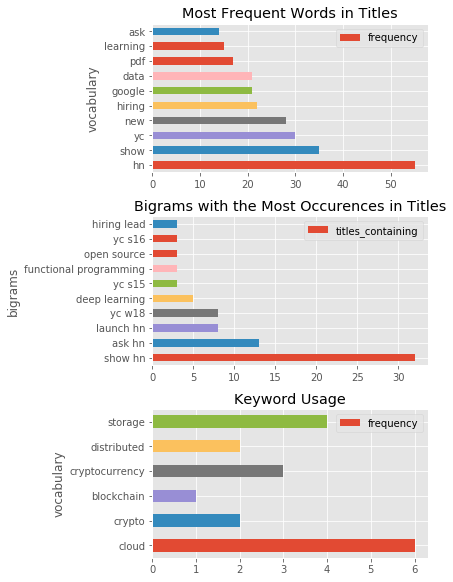

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=1)
top_ten = text_df.iloc[0:10]
top_ten_bigrams = bigrams_df.iloc[0:10]
keywords = text_df.loc[['cloud', 'crypto', 'blockchain', 'cryptocurrency', 'distributed', 'storage']]
top_ten.plot(y='frequency', kind='barh', title='Most Frequent Words in Titles', ax=axes[0], figsize=(6, 8))
top_ten_bigrams.plot(y='titles_containing', kind='barh', title='Bigrams with the Most Occurences in Titles', 
                     ax=axes[1], figsize=(6,8))
keywords.plot(y='frequency', kind='barh', title='Keyword Usage', ax=axes[2], figsize=(6,8))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### General Hacker News Visualizations (Only Stories Included)

In [137]:
jobs = df['type'].isin(['job'])
df = df[~jobs]

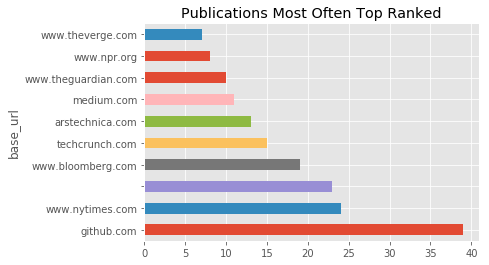

In [139]:
publications = df.groupby('base_url').size().sort_values(ascending=False)
top_publications = publications.iloc[0:10]
top_publications.plot(kind='barh', title='Publications Most Often Top Ranked')

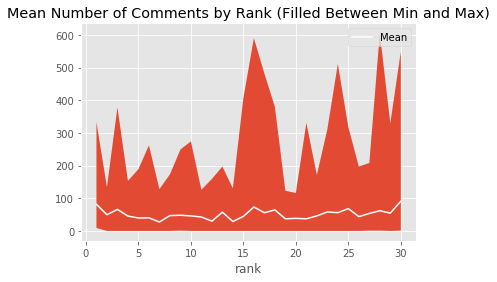

In [176]:
rank_comments = df.groupby('rank', as_index=False)['descendants'].agg({'Min': 'min', 'Max': 'max', 'Mean': 'mean'})
ax = rank_comments.plot(x='rank', title='Mean Number of Comments by Rank (Filled Between Min and Max)', y='Mean', c='white')
plt.fill_between(x=rank_comments['rank'], y1=rank_comments['Min'], y2=rank_comments['Max'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

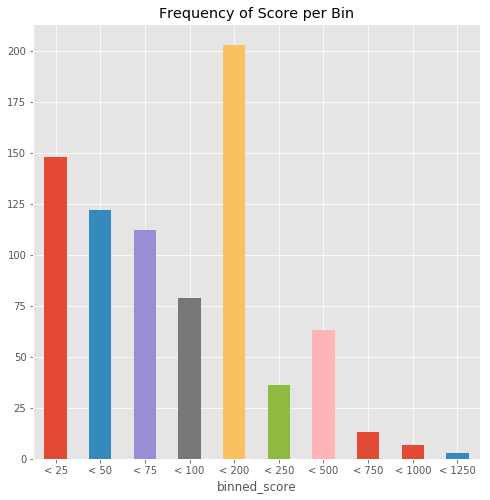

In [166]:
bins = [0, 25, 50, 75, 100, 200, 250, 500, 750, 1000, 1250]
labels = ['< 25', '< 50', '< 75', '< 100', '< 200', '< 250', '< 500', '< 750', '< 1000', '< 1250']
df['binned_score'] = pd.cut(df['score'], bins=bins, labels=labels)
bin_groups = df.groupby('binned_score')['score'].count()
bin_groups.plot(kind='bar', title='Frequency of Score per Bin', figsize=(8,8))
plt.xticks(rotation='horizontal')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

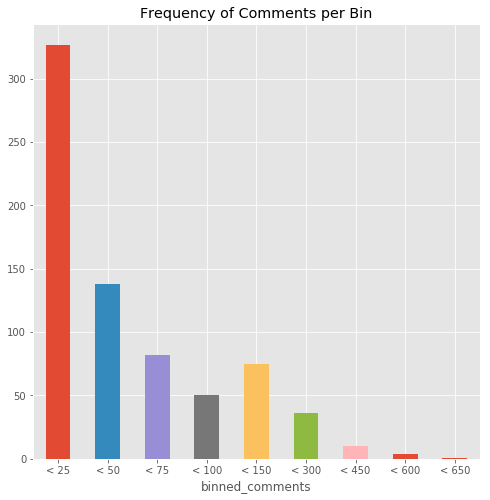

In [172]:
bins = [0, 25, 50, 75, 100, 150, 300, 450, 600, 650]
labels = ['< 25', '< 50', '< 75', '< 100', '< 150', '< 300', '< 450', '< 600', '< 650']
df['binned_comments'] = pd.cut(df['descendants'], bins=bins, labels=labels)
bin_comments = df.groupby('binned_comments')['descendants'].count()
bin_comments.plot(kind='bar', title='Frequency of Comments per Bin', figsize=(8,8))
plt.xticks(rotation='horizontal')

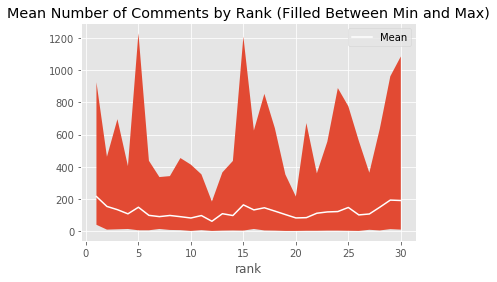

In [175]:
scores = df.groupby('rank', as_index=False)['score'].agg({'Low': 'min', 'High': 'max', 'Mean': 'mean'})
ax = scores.plot(x='rank', title='Mean Number of Comments by Rank (Filled Between Min and Max)', y='Mean', c='white')
plt.fill_between(x=scores['rank'], y1=scores['Low'], y2=scores['High'])

## Conclusions

* Text mining can be used to get a view of hot topics for top ranked stories
* We can't make any definitive judgement about the characteristics of a Top 5 vs. Top 30 by comments or score - pointing to the relevance of time in the HN ranking algorithm
* There are very large spreads for scores and comment counts across ranks
* We can easily distinguish publications most often in Top 30

### Potential Areas of Further Research
* Use larger datasets to gather more robust view of topics by title
* Collect data for "peak performance" of top stories
* Collect full story content and use NLP models to derive importance of words for content for certain keywords (blockchain, open-source, 'crypto', 'cloud storage', etc)
* Tag content by category using statistical models